In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2

### Utils file

In [157]:
def calculate_outputs_and_gradients(inputs, model, target_label_idx, cuda=False):
    # do the pre-processing
    predict_idx = None
    gradients = []
    for input in inputs:
        input = pre_processing(input, cuda)
        output = model(input)
        output = F.softmax(output, dim=1)
        if target_label_idx is None:
            target_label_idx = torch.argmax(output, 1).item()
        index = np.ones((output.size()[0], 1)) * target_label_idx
        index = torch.tensor(index, dtype=torch.int64)
        if cuda:
            index = index.cuda()
        output = output.gather(1, index)
        # clear grad
        model.zero_grad()
        output.backward()
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx

def pre_processing(obs, cuda):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    obs = obs / 255
    obs = (obs - mean) / std
    obs = np.transpose(obs, (2, 0, 1))
    obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    if cuda:
        torch_device = torch.device('cuda:0')
    else:
        torch_device = torch.device('cpu')
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=torch_device, requires_grad=True)
    return obs_tensor

# generate the entire images
def generate_entrie_images(img_origin, img_grad, img_grad_overlay, img_integrad, img_integrad_overlay):
    blank = np.ones((img_grad.shape[0], 5, 3), dtype=np.uint8) * 255
    blank_hor = np.ones((10, 10 + img_grad.shape[1] * 3, 3), dtype=np.uint8) * 255
    upper = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_grad_overlay, blank, img_grad], 1)
    down = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_integrad_overlay, blank, img_integrad], 1)

    print(upper.shape, blank_hor.shape, down.shape)
    total = np.concatenate([upper, blank_hor, down], 0)
    # total = cv2.resize(total, (550, 364))

    return total


### integrated gradients file

In [3]:
# integrated gradients
def integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, baseline, steps=50, cuda=False):
    if baseline is None:
        baseline = 0 * inputs
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = predict_and_gradients(scaled_inputs, model, target_label_idx, cuda)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.transpose(avg_grads, (1, 2, 0))
    delta_X = (pre_processing(inputs, cuda) - pre_processing(baseline, cuda)).detach().squeeze(0).cpu().numpy()
    delta_X = np.transpose(delta_X, (1, 2, 0))
    integrated_grad = delta_X * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, steps, num_random_trials, cuda):
    all_intgrads = []
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, \
                                                baseline=255.0 *np.random.random(inputs.shape), steps=steps, cuda=cuda)
        all_intgrads.append(integrated_grad)
        print('the trial number is: {}'.format(i))
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads

### Visualization File

In [4]:

G = [0, 255, 0]
R = [255, 0, 0]

def convert_to_gray_scale(attributions):
    return np.average(attributions, axis=2)

def linear_transform(attributions, clip_above_percentile=99.9, clip_below_percentile=70.0, low=0.2, plot_distribution=False):
    m = compute_threshold_by_top_percentage(attributions, percentage=100-clip_above_percentile, plot_distribution=plot_distribution)
    e = compute_threshold_by_top_percentage(attributions, percentage=100-clip_below_percentile, plot_distribution=plot_distribution)
    transformed = (1 - low) * (np.abs(attributions) - e) / (m - e) + low
    transformed *= np.sign(attributions)
    transformed *= (transformed >= low)
    transformed = np.clip(transformed, 0.0, 1.0)
    return transformed

def compute_threshold_by_top_percentage(attributions, percentage=60, plot_distribution=True):
    if percentage < 0 or percentage > 100:
        raise ValueError('percentage must be in [0, 100]')
    if percentage == 100:
        return np.min(attributions)
    flat_attributions = attributions.flatten()
    attribution_sum = np.sum(flat_attributions)
    sorted_attributions = np.sort(np.abs(flat_attributions))[::-1]
    cum_sum = 100.0 * np.cumsum(sorted_attributions) / attribution_sum
    threshold_idx = np.where(cum_sum >= percentage)[0][0]
    threshold = sorted_attributions[threshold_idx]
    if plot_distribution:
        raise NotImplementedError
    return threshold

def polarity_function(attributions, polarity):
    if polarity == 'positive':
        return np.clip(attributions, 0, 1)
    elif polarity == 'negative':
        return np.clip(attributions, -1, 0)
    else:
        raise NotImplementedError

def overlay_function(attributions, image):
    return np.clip(0.7 * image + 0.5 * attributions, 0, 255)

def visualize(attributions, image, positive_channel=G, negative_channel=R, polarity='positive', \
                clip_above_percentile=99.9, clip_below_percentile=0, morphological_cleanup=False, \
                structure=np.ones((3, 3)), outlines=False, outlines_component_percentage=90, overlay=True, \
                mask_mode=False, plot_distribution=False):
    if polarity == 'both':
        raise NotImplementedError

    elif polarity == 'positive':
        attributions = polarity_function(attributions, polarity=polarity)
        channel = positive_channel

    # convert the attributions to the gray scale
    attributions = convert_to_gray_scale(attributions)
    attributions = linear_transform(attributions, clip_above_percentile, clip_below_percentile, 0.0, plot_distribution=plot_distribution)
    attributions_mask = attributions.copy()
    if morphological_cleanup:
        raise NotImplementedError
    if outlines:
        raise NotImplementedError
    attributions = np.expand_dims(attributions, 2) * channel
    if overlay:
        if mask_mode == False:
            attributions = overlay_function(attributions, image)
        else:
            attributions = np.expand_dims(attributions_mask, 2)
            attributions = np.clip(attributions * image, 0, 255)
            attributions = attributions[:, :, (2, 1, 0)]
    return attributions

### Main file

In [101]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import cv2
import time

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Text(0.5, 1.0, 'bird')

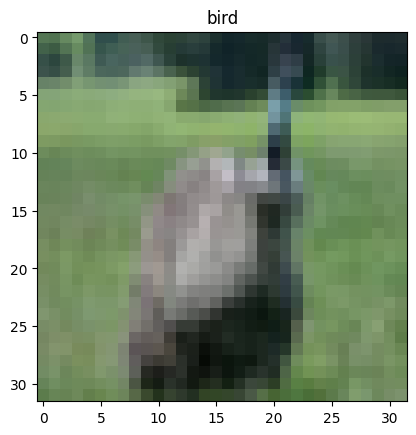

In [102]:
import matplotlib.pyplot as plt
num = 1050
plt.imshow(np.transpose(train_dataset[num][0], (1, 2, 0)))
plt.title(classes[train_dataset[num][1]])

In [109]:
def pgd_untargeted(model, x, labels, eps, eps_step, num_itr=15, device='cpu'):
    x_new = x.clone().requires_grad_(True)
    L = nn.CrossEntropyLoss()

    for i in range(num_itr):
        x_new = x_new.clone().detach().to(device).requires_grad_(True)
        loss = L(model(x_new), labels)
        loss.backward()
        with torch.no_grad():
            x_new = x_new + x_new.grad.sign() * eps_step
        x_new = torch.clamp(x_new, x - eps, x + eps)
        x_new = x_new.clamp(*(0, 1))
    return x_new

def train_model(model, num_epochs, enable_defense=True, device='cpu'):
    model.train()
    learning_rate = 0.0001

    opt = optim.Adam(params=model.parameters(), lr=learning_rate)

    ce_loss = torch.nn.CrossEntropyLoss()

    tot_steps = 0

    for epoch in range(1,num_epochs+1):
        t1 = time.time()
        for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if enable_defense:
                x_batch = pgd_untargeted(model, x_batch, y_batch, 10.0/256, 1.0/256, device=device)

            tot_steps += 1
            opt.zero_grad()
            out = model(x_batch)
            batch_loss = ce_loss(out, y_batch)
            batch_loss.backward()
            opt.step()

        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        t2 = time.time()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))
    return model

In [110]:
model = models.resnet18()
model.to(device)
model = train_model(model, 15, enable_defense=True, device=device)

Epoch 1: Accuracy 0.20470 [175.02 seconds]
Epoch 2: Accuracy 0.26950 [174.41 seconds]
Epoch 3: Accuracy 0.33720 [174.51 seconds]
Epoch 4: Accuracy 0.37750 [175.48 seconds]
Epoch 5: Accuracy 0.41470 [174.50 seconds]
Epoch 6: Accuracy 0.42800 [174.63 seconds]
Epoch 7: Accuracy 0.44820 [174.26 seconds]
Epoch 8: Accuracy 0.46420 [174.48 seconds]
Epoch 9: Accuracy 0.48740 [175.21 seconds]
Epoch 10: Accuracy 0.49410 [175.22 seconds]
Epoch 11: Accuracy 0.49790 [174.56 seconds]
Epoch 12: Accuracy 0.50580 [174.62 seconds]
Epoch 13: Accuracy 0.50890 [174.64 seconds]
Epoch 14: Accuracy 0.52480 [175.02 seconds]
Epoch 15: Accuracy 0.52540 [174.91 seconds]


In [111]:
model = train_model(model, 10, enable_defense=True, device=device)

Epoch 1: Accuracy 0.53250 [175.87 seconds]
Epoch 2: Accuracy 0.52670 [174.26 seconds]
Epoch 3: Accuracy 0.54910 [174.42 seconds]
Epoch 4: Accuracy 0.54810 [174.88 seconds]
Epoch 5: Accuracy 0.54450 [175.12 seconds]
Epoch 6: Accuracy 0.54440 [174.27 seconds]
Epoch 7: Accuracy 0.56900 [174.46 seconds]
Epoch 8: Accuracy 0.56560 [174.60 seconds]
Epoch 9: Accuracy 0.55980 [174.52 seconds]
Epoch 10: Accuracy 0.56790 [175.25 seconds]


In [112]:
model = train_model(model, 10, enable_defense=True, device=device)

Epoch 1: Accuracy 0.55820 [176.12 seconds]
Epoch 2: Accuracy 0.56650 [174.65 seconds]
Epoch 3: Accuracy 0.56420 [174.53 seconds]
Epoch 4: Accuracy 0.56220 [174.39 seconds]
Epoch 5: Accuracy 0.56330 [174.58 seconds]
Epoch 6: Accuracy 0.57190 [175.35 seconds]
Epoch 7: Accuracy 0.56380 [174.62 seconds]
Epoch 8: Accuracy 0.56720 [174.64 seconds]
Epoch 9: Accuracy 0.57240 [174.50 seconds]
Epoch 10: Accuracy 0.56670 [174.55 seconds]


Text(0.5, 1.0, 'frog')

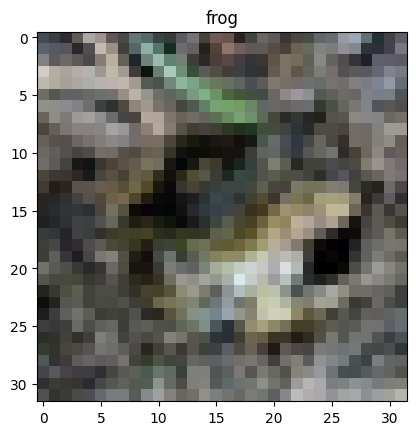

In [171]:
model.eval()
# read the image
num_sample = 2050
img = train_dataset[num_sample][0].numpy()

plt.imshow(np.transpose(img, (1, 2, 0)).astype(np.float32) )
plt.title(classes[train_dataset[num_sample][1]])

In [172]:
img_temp = torch.unsqueeze(torch.tensor(img), 0)
print(img_temp.shape)
out = model(img_temp.to(device))
pred = torch.max(out, dim=1)[1]
print(classes[pred[0]], classes[train_dataset[num_sample][1]])

torch.Size([1, 3, 32, 32])
frog frog


In [173]:
# calculate the gradient and the label index
img_in = np.transpose(img, (1, 2, 0)).astype(np.float32)
gradients, label_index = calculate_outputs_and_gradients([img_in], model, None, device)
gradients = np.transpose(gradients[0], (1, 2, 0))
print(gradients.shape, classes[label_index])
img_gradient_overlay = visualize(gradients, img_in, clip_above_percentile=99, clip_below_percentile=0, overlay=True, mask_mode=True)
img_gradient = visualize(gradients, img, clip_above_percentile=99, clip_below_percentile=0, overlay=False)
print(img_gradient_overlay.shape, img_gradient.shape)

(32, 32, 3) deer
(32, 32, 3) (32, 32, 3)


In [174]:
# calculae the integrated gradients
attributions = random_baseline_integrated_gradients(img_in, model, label_index, calculate_outputs_and_gradients, steps=50, num_random_trials=10, cuda=use_cuda)
img_integrated_gradient_overlay = visualize(attributions, img_in, clip_above_percentile=99, clip_below_percentile=0, overlay=True, mask_mode=True)
img_integrated_gradient = visualize(attributions, img_in, clip_above_percentile=99, clip_below_percentile=0, overlay=False)
print(img_integrated_gradient_overlay.shape, img_integrated_gradient.shape)
output_img = generate_entrie_images(img_in, img_gradient, img_gradient_overlay, img_integrated_gradient, img_integrated_gradient_overlay)

the trial number is: 0
the trial number is: 1
the trial number is: 2
the trial number is: 3
the trial number is: 4
the trial number is: 5
the trial number is: 6
the trial number is: 7
the trial number is: 8
the trial number is: 9
(32, 32, 3) (32, 32, 3)
(32, 106, 3) (10, 106, 3) (32, 106, 3)


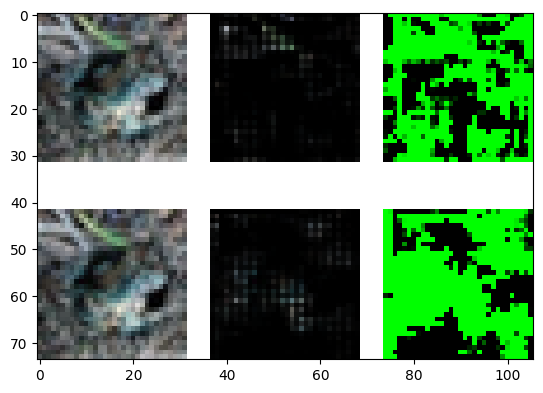

In [175]:
plt.imshow(output_img)